In [1]:
# import modules
import uproot, sys, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from scipy.special import betainc
from scipy.stats import norm

# import config functions
from jet_faking_plot_config import getWeight, zbi, sample_dict, getVarDict
from plot_var import variables, variables_data, ntuple_names, ntuple_names_BDT


# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [2]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
path = "/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_ggHyyd_y_BDT_score.root"
f = uproot.open(path)['nominal']
f.keys()

['run',
 'randomRunNumber',
 'event',
 'year',
 'averageIntPerXing',
 'actualIntPerXing',
 'corAverageIntPerXing',
 'corActualIntPerXing',
 'trigger_HLT_g100_loose_L1EM22VHI',
 'trigger_HLT_g100_loose_L1eEM26M',
 'trigger_HLT_g100_loose_L1eEM28M',
 'trigger_HLT_g120_loose_L1EM22VHI',
 'trigger_HLT_g120_loose_L1eEM26M',
 'trigger_HLT_g120_loose_L1eEM28MHLT_g25_loose_L1EM20VH',
 'trigger_HLT_g140_loose_L1EM22VHI',
 'trigger_HLT_g140_loose_L1eEM26M',
 'trigger_HLT_g25_loose_L1eEM24L',
 'trigger_HLT_g30_loose_L1EM20VH',
 'trigger_HLT_g30_loose_L1eEM24L',
 'trigger_HLT_g40_loose_L1EM20VH',
 'trigger_HLT_g40_loose_L1eEM24L',
 'trigger_HLT_g50_loose_L1EM20VH',
 'trigger_HLT_g50_loose_L1eEM24L',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe70_pf

In [26]:
tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []
ntuple_names = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct', 'data23']

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 0
for i in [1, 4]:
    ucut, wcut = [], []
    start_time = time.time()
    ntuple_name = ntuple_names[i]
    if ntuple_name == 'data23':
        path = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/data23_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables+['event', 'BDTScore'], library="ak")
    else:
        path = f"/data/tmathew/ntups/mc23d/{ntuple_name}_y.root" 
        path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name}_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables, library="ak")

        # add BDT score to fb
        f_BDT = uproot.open(path_BDT)['nominal']
        fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
        tmp = fb["event"] == fb_BDT["event"]
        if np.all(tmp) == True:
            fb["BDTScore"] = fb_BDT["BDTScore"]
        else: 
            print("Something is wrong, need arranging")


    # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
    fb = fb[ak.num(fb['ph_eta']) > 0]
    # Zjets and Wjets (rule out everything except for e->gamma)
    if ntuple_name == 'Zjets' or ntuple_name == 'Wjets':
        mask1 = ak.firsts(fb['ph_truth_type']) >= 1
        mask2 = ak.firsts(fb['ph_truth_type']) <= 4
        fb = fb[mask1 & mask2]

    print("Unweighted Events before cut: ", len(fb))
    print("Weighted Events before cut: ", sum(getWeight(fb, ntuple_name, jet_faking=True)))

    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0



processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  4089643
Weighted Events before cut:  8518457.689883482
processing file:  /data/tmathew/ntups/mc23d/Wjets_y.root
Unweighted Events before cut:  2463995
Weighted Events before cut:  5147548.389972768


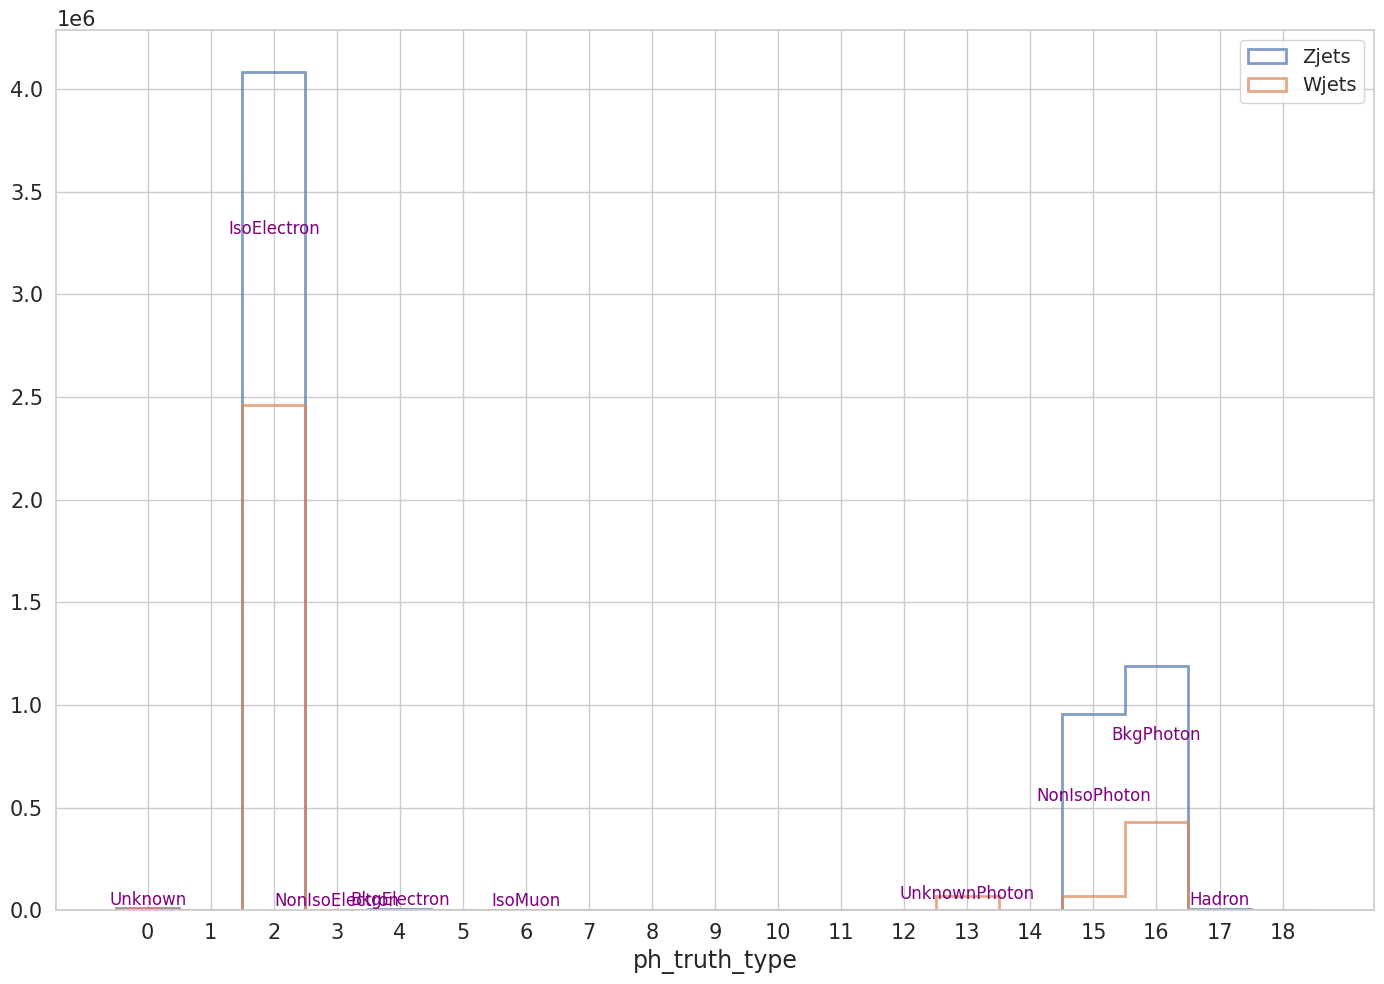

In [ ]:
truth_type_map = {
    0: "Unknown",
    1: "UnknownElectron",
    2: "IsoElectron",
    3: "NonIsoElectron",
    4: "BkgElectron",
    5: "UnknownMuon",
    6: "IsoMuon",
    7: "NonIsoMuon",
    8: "BkgMuon",
    9: "UnknownTau",
    10: "IsoTau",
    11: "NonIsoTau",
    12: "BkgTau",
    13: "UnknownPhoton",
    14: "IsoPhoton",
    15: "NonIsoPhoton",
    16: "BkgPhoton",
    17: "Hadron",
    18: "Neutrino",
}

bins = np.arange(-0.5, 19.5, 1)

# Histogram 1: Zjets
fb = tot[0]
data_zjets = ak.firsts(fb['ph_truth_type'])
counts_zjets, _ = np.histogram(data_zjets, bins=bins)
plt.hist(data_zjets, bins=bins, linewidth=2, histtype='step', alpha=0.7, label="Zjets")

# Histogram 2: Wjets
fb = tot[1]
data_wjets = ak.firsts(fb['ph_truth_type'])
counts_wjets, _ = np.histogram(data_wjets, bins=bins)
plt.hist(data_wjets, bins=bins, linewidth=2, histtype='step', alpha=0.7, label="Wjets")

# Label non-zero bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
total_counts = counts_zjets + counts_wjets
for i, count in enumerate(total_counts):
    if count > 0 and i in truth_type_map:
        plt.text(bin_centers[i], count*0.5, truth_type_map[i],
                 ha='center', va='bottom', color='purple', fontsize=12)

plt.xticks(np.arange(0, 19, 1))
plt.xlabel("ph_truth_type")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []
ntuple_names = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct', 'data23']

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

def print_cut(ntuple_name, fb, label):
    print(f"Unweighted Events {label}: ", len(fb))
    if ntuple_name == 'data23':
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name, jet_faking=True)))
    else: 
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name)))

for i in range(len(ntuple_names)):
    ucut, wcut = [], []
    start_time = time.time()
    ntuple_name = ntuple_names[i]
    if ntuple_name == 'data23': # data
        path = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/data23_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables_data, library="ak")
        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
                
        mask1 = (ak.firsts(fb['ph_topoetcone40'])-2450.)/ak.firsts(fb['ph_pt']) < 0.1   # jet_faking_photon cut
        fb = fb[mask1]
        fb = fb[fb['n_ph_baseline'] == 1]

    else: # MC
        path = f"/data/tmathew/ntups/mc23d/{ntuple_name}_y.root" 
        path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name}_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables, library="ak")

        # add BDT score to fb
        f_BDT = uproot.open(path_BDT)['nominal']
        fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
        tmp = fb["event"] == fb_BDT["event"]
        if np.all(tmp) == True:
            fb["BDTScore"] = fb_BDT["BDTScore"]
        else: 
            print("Something is wrong, need arranging")

        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
        fb = fb[fb['n_ph'] == 1]

    

    # Zjets and Wjets (rule out everything except for e->gamma)
    if ntuple_name == 'Zjets' or ntuple_name == 'Wjets':
        mask1 = ak.firsts(fb['ph_truth_type']) == 2
        mask2 = ak.firsts(fb['ph_truth_type']) == 2
        fb = fb[mask1 & mask2]
    
    print_cut(ntuple_name, fb, 'before cut')


    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)
    # goodPV on signal only
    if ntuple_name == 'ggHyyd':
        fb = fb[ak.num(fb['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
        fb = fb[good_pv_tmp]

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 100 # trigger cut
    fb = fb[mask1]
    
    fb = fb[fb['BDTScore'] >= 0.1] # added cut 1

    print_cut(ntuple_name, fb, 'after basic cut')


    # metsig_tmp = fb['met_tst_sig'] # added cut 2 
    # mask1 = metsig_tmp >= 7
    # fb = fb[mask1]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    # fb = fb[dphi_met_phterm_tmp >= 1.35]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et'] # added cut 4
    # mask1 = dmet_tmp >= -20000
    # mask2 = dmet_tmp <= 50000
    # fb = fb[mask1 * mask2]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
    #                         np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
    #                         -999)
    # fb = fb[dphi_met_jetterm_tmp <= 0.7]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta'])) # added cut 6
    # fb = fb[ph_eta_tmp <= 1.75]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # phi1_tmp = ak.firsts(fb['jet_central_phi']) # added cut 7
    # phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1] 
    # dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    # dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
    # fb = fb[dphi_jj_tmp <= 2.5]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))


    # jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
    # expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
    # balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
    # fb = fb[balance_tmp >= 0.65]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name)))

    # mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
    #                     (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    # mask1 = mt_tmp >= 95
    # fb = fb[mask1]

    # print_cut(ntuple_name, fb)
    ucut.append(len(fb))
    if ntuple_name == 'data23':
        wcut.append(sum(getWeight(fb, ntuple_name, jet_faking=True)))
    else: 
        wcut.append(sum(getWeight(fb, ntuple_name)))


    unweighted_acut.append(ucut)
    weighted_acut.append(wcut)
    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  195671
Weighted Events before cut:  19979.121
Unweighted Events after basic cut:  3729
Weighted Events after basic cut:  375.93835
Number of none values:  0
Reading Time for ggHyyd: 1.3622899055480957 seconds

processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  3242488
Weighted Events before cut:  674497.9
Unweighted Events after basic cut:  5164
Weighted Events after basic cut:  124.29326
Number of none values:  0
Reading Time for Zjets: 88.61976885795593 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  3423357
Weighted Events before cut:  249515.86
Unweighted Events after basic cut:  704359
Weighted Events after basic cut:  16750.656
Number of none values:  0
Reading Time for Zgamma: 34.93812298774719 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1308982
Weighte

In [30]:
Vars = [
    'metsig',
    'metsigres',
    'met',
    'met_noJVT',
    'dmet',
    'ph_pt',
    'ph_eta',
    'ph_phi',
    'jet_central_eta',
    'jet_central_pt1',
    'jet_central_pt2',
    'dphi_met_phterm',
    'dphi_met_ph',
    'dphi_met_jetterm',
    'dphi_phterm_jetterm',
    'dphi_ph_centraljet1',
    'dphi_ph_jet1',
    'metplusph',
    'failJVT_jet_pt1',
    'softerm',
    'jetterm',
    'jetterm_sumet',
    'dphi_met_central_jet',
    'balance',
    'dphi_jj',
    'BDTScore',
    'n_jet_central'
]

data_list = []

for j in range(len(ntuple_names)):
    process = ntuple_names[j]
    fb = tot[j] 
    
    data_dict = {}
    
    for var in Vars:
        var_config = getVarDict(fb, process, var_name=var)
        data_dict[var] = var_config[var]['var']
    
    weights = getWeight(fb, process)
    data_dict['weights'] = weights
    
    n_events = len(weights)
    data_dict['process'] = [process] * n_events
    label = 1 if process == 'ggHyyd' else 0
    data_dict['label'] = [label] * n_events
    
    df_temp = pd.DataFrame(data_dict)
    data_list.append(df_temp)

df_all = pd.concat(data_list, ignore_index=True)
df_all.head()

df_all.to_csv("/data/jlai/ntups/csv/jet_faking_BDT_input_basic.csv", index=False)


In [31]:
def sel(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]

        # jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        # expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        # balance_tmp = ak.where(jet_sum_tmp != 0, expr, -999)
        # mask1 = balance_tmp >= 0.65
        # mask2 = balance_tmp == -999
        # fb2 = fb2[mask1 | mask2]
        
        metsig_tmp = fb2['met_tst_sig'] 
        mask1 = metsig_tmp >= 7
        fb2 = fb2[mask1]
        # mask2 = metsig_tmp <= 13
        # fb2 = fb2[mask1 * mask2]
        
        # ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta']))
        # fb2 = fb2[ph_eta_tmp <= 1.75]

        dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) # added cut 3
        fb2 = fb2[dphi_met_phterm_tmp >= 1.55]

        # dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et']
        # mask1 = dmet_tmp >= -20000
        # mask2 = dmet_tmp <= 50000
        # fb2 = fb2[mask1 * mask2]

        # phi1_tmp = ak.firsts(fb2['jet_central_phi']) # added cut 7
        # phi2_tmp = ak.mask(fb2['jet_central_phi'], ak.num(fb2['jet_central_phi']) >= 2)[:, 1] 
        # dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        # dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
        # fb2 = fb2[dphi_jj_tmp <= 2.5]

        # dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
        #                     np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
        #                     -999)
        # fb2 = fb2[dphi_met_jetterm_tmp <= 0.70]

        # mt_tmp = np.sqrt(2 * fb2['met_tst_et'] * ak.firsts(fb2['ph_pt']) * 
        #                     (1 - np.cos(fb2['met_tst_phi'] - ak.firsts(fb2['ph_phi'])))) / 1000
        # mask1 = mt_tmp >= 95
        # fb2 = fb2[mask1]

        
        tot2.append(fb2)
    return tot2

tot2 = sel(tot)
# tot2 = tot

cut_name = 'metsig'
# var_config = getVarDict(tot2[0], 'ggHyyd', var_name='balance')
# cut_name = 'mt2'
var_config = getVarDict(tot2[0], 'ggHyyd')


for var in var_config:
    # print(var)
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    for j in range(len(ntuple_names)):
    # for j in range(len(ntuple_names)-1): # leave dijet out
        process = ntuple_names[j]
        fb = tot2[j]  # TTree
        var_config = getVarDict(fb, process, var_name=var)

        x = var_config[var]['var'] # TBranch
        bins = var_config[var]['bins'] 

        if 'weight' in var_config[var]:  # If weight is there
            weights = var_config[var]['weight']
        else:
            weights = getWeight(fb, process)
        
        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)
    # ax_top.set_title("vtx_sumPt distribution")

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance
    sig_simple = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

    sqrt_B = np.sqrt(B_counts)
    sqrt_SplusB = np.sqrt(S_counts + B_counts)
    sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

    # Avoid division by zero safely
    sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

    # Add Binomial ExpZ per bin
    zbi_per_bin = np.array([
        zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
        for i in range(len(S_counts))
    ])

    # Compute the bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)

    if total_bkg > 0:
        total_sig_simple = total_signal / np.sqrt(total_bkg)
        total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
        total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
        total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
    else:
        total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

    # --- Plot all significance curves ---
    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("Significance")
    ax_bot.set_ylim(-0.8, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    plt.tight_layout()
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"successfully saved to ../jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    # Use the vtx_sumPt values as the classifier output.
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    print(f"successfully saved to ../jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/vtx_sumPt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_vtx_sumPt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_ph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_ph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_ph_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_ph_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_el_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_el_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_mu_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_mu_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_tau_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_tau_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/mt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_mt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/metsig_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_metsig.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/metsigres_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_metsigres.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/met_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_met.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/met_noJVT_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_met_noJVT.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/met_cst_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_met_cst.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/met_track_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_met_track.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dmet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dmet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/ph_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_ph_pt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/ph_eta_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_ph_eta.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/ph_phi_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_ph_phi.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_eta_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_eta.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_pt1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_pt1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_pt2_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_pt2.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_pt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_met_phterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_met_phterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_met_ph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_met_ph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_met_jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_met_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_phterm_jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_phterm_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_ph_centraljet1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_ph_centraljet1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_ph_jet1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_ph_jet1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/metplusph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_metplusph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/failJVT_jet_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_failJVT_jet_pt.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/failJVT_jet_pt1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_failJVT_jet_pt1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/softerm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_softerm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jetterm_sumet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jetterm_sumet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_jet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_jet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_jet_central_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_jet_central.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/n_jet_fwd_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_n_jet_fwd.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_met_central_jet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_met_central_jet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_timing1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_timing1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_timing_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_timing.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/jet_central_emfrac_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_jet_central_emfrac.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/balance_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_balance.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/balance_sumet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_balance_sumet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/central_jets_fraction_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_central_jets_fraction.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/trigger_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_trigger.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/dphi_jj_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_dphi_jj.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/BDTScore_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_metsigcut/roc_curve_BDTScore.png


In [9]:
process

'd'

In [ ]:
# print out the image list in common_config.js
var_config = getVarDict(tot2[0], 'ggHyyd')

for var in var_config:

    print(f"'mc23d_balancecut/{var}_nodijet.png',")
    print(f"'mc23d_abs_weight_selectioncut/{var}_absWeightSelection.png',")

'mc23d_balancecut/vtx_sumPt_nodijet.png',
'mc23d_abs_weight_selectioncut/vtx_sumPt_absWeightSelection.png',
'mc23d_balancecut/n_ph_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_absWeightSelection.png',
'mc23d_balancecut/n_ph_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_baseline_absWeightSelection.png',
'mc23d_balancecut/n_el_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_el_baseline_absWeightSelection.png',
'mc23d_balancecut/n_mu_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_mu_baseline_absWeightSelection.png',
'mc23d_balancecut/n_tau_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_tau_baseline_absWeightSelection.png',
'mc23d_balancecut/puWeight_nodijet.png',
'mc23d_abs_weight_selectioncut/puWeight_absWeightSelection.png',
'mc23d_balancecut/actualIntPerXing_nodijet.png',
'mc23d_abs_weight_selectioncut/actualIntPerXing_absWeightSelection.png',
'mc23d_balancecut/mt_nodijet.png',
'mc23d_abs_weight_selectioncut/mt_absWeightSelection.png',
'mc23d

## Back-up

In [ ]:

    var = {
        'vtx_sumPt': ak.flatten(fb['vtx_sumPt']),
        'n_ph': fb['n_ph'],
        'n_ph_baseline': fb['n_ph_baseline'],
        'n_el_baseline': fb['n_el_baseline'],
        'n_mu_baseline': fb['n_mu_baseline'],
        'n_tau_baseline': fb['n_tau_baseline'],
        'puWeight': fb['pu_weight'],
        'actualIntPerXing': fb['actualIntPerXing'],
        'mt': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
        'metsig': fb['met_tst_sig'],
        'metsigres': fb['met_tst_et'] / fb['met_tst_sig'],
        'met': fb['met_tst_et'],  # applying the '+50000' shift
        'met_noJVT': fb['met_tst_noJVT_et'],
        'met_cst': fb['met_cst_et'],
        'met_track': fb['met_track_et'],
        'dmet': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
        'ph_pt': ak.firsts(fb['ph_pt']),  # applying the '-150000' shift
        'ph_eta': np.abs(ak.firsts(fb['ph_eta'])),
        'ph_phi': ak.firsts(fb['ph_phi']),
        # 'jet_central_eta': ak.firsts(fb['jet_central_eta']),
        # 'jet_central_pt1': ak.firsts(fb['jet_central_pt']),
        # 'jet_central_pt2': fb['jet_central_pt'][ak.num(fb['jet_central_pt']) >= 2][:, 1],
        # 'jet_central_pt': fb['jet_central_pt'],
        'dphi_met_phterm': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
        'dphi_met_ph': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
        'dphi_met_jetterm': np.where(fb['met_jetterm_et'] != 0,
                                    np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                                    0),
        'dphi_phterm_jetterm': np.where(fb['met_jetterm_et'] > 0,
                                        np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                                        4),
        # 'dphi_ph_centraljet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_ph_jet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_central_jet1_jet2': np.arccos(np.cos(fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 0] - fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 1])),
        'metplusph': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
        # 'failJVT_jet_pt': fb['failJVT_jet_pt'],
        # 'failJVT_jet_pt1': ak.firsts(fb['failJVT_jet_pt']),
        'softerm': fb['met_softerm_tst_et'],
        'jetterm': fb['met_jetterm_et'],
        'jetterm_sumet': fb['met_jetterm_sumet'],
        'n_jet': fb['n_jet'],
        'n_jet_central': fb['n_jet_central'],
        'n_jet_fwd': fb['n_jet'] - fb['n_jet_central'],
        'vertex': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z'])),
        'goodPV': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5,
        # 'dphi_met_central_jet': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi']))),
        # 'counts': 0.5,
        # 'jet_central_timing1': ak.firsts(fb['jet_central_timing']),
        # 'jet_central_timing': fb['jet_central_timing'],
        # 'jet_central_emfrac': fb['jet_central_emfrac'],
        # 'jet_central_emfrac1': ak.firsts(fb['jet_central_emfrac']),
        'balance': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / np.sum(fb['jet_central_pt']), # need fixing 
        'balance_sumet': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / fb['met_jetterm_sumet'],
        'central_jets_fraction': np.where(fb['n_jet'] > 0, fb['n_jet_central'] / fb['n_jet'], -1),
        'trigger': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
        # 'dphi_jj': ak.Array([np.arccos(np.cos(phi[1] - phi[0])) if len(phi) > 1 else -1 for phi in fb['jet_central_phi']])
    }

    df = pd.DataFrame(var)

    data = pd.concat([data, df], ignore_index=True)


    # for key, value in var.items():
    #     try:
    #         print(f"{key:30s}: {len(value)}")
    #         print(f"{key:30s}: {value[:5]}")

    #     except Exception as e:
    #         print(f"{key:30s}: error getting length ({e})")

print(data.head())
